In [1]:
import os
import sys
# sys.path.insert(0, os.path.relpath('../..'))
sys.path.insert(0, os.path.relpath('../../../../..')) 

In [2]:
from recidiviz.calculator.modeling.population_projection.super_simulation import SuperSimulation
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation.py:92: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  def _convert_to_relative_date_from_timestamp(self, timestamp: pd.datetime):


In [3]:
test = open('../state/AZ/az_state_prison_2808_model_inputs.yaml')
test_sim = SuperSimulation(test)
# test_sim.simulate_baseline('pre-trial', 'prison')

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


initialization time:  18.904586791992188
simulation_time:  9.861234188079834
initialization time:  19.551492929458618
simulation_time:  9.441213130950928


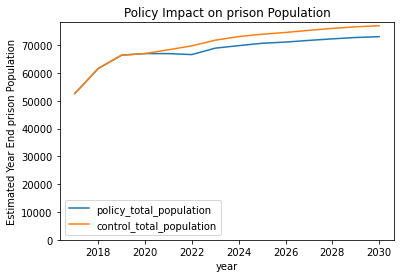

In [4]:
is_violent_map = {
    'arson': True,
    'assault': True,
    'auto_theft': False,
    'burglary_or_criminal_trespass': True, # only certain kinds of burglary
    'child_or_adult_abuse': True, # only child abuse would be violent?
    'child_molestation': True,
    'criminal_damage': False,
    'domestic_violence': False,
    'drug_possession': False,
    'drug_trafficking': False,
    'dui': False,
    'escape': False,
    'forgery': False,
    'fraud': False,
    'identity_theft': False,
    'kidnapping': True,
    'manslaughter_or_neg_homicide': True,
    'murder': True,
    'other': False,
    'rape_or_sexual_assault': True,
    'robbery': True,
    'sex_offense': False,
    'theft': False,
    'trafficking_in_stolen_property': False,
    'weapons_offense': True,
}


SENTENCE_LENGTH_REDUCTION = 15/85 
AFFECTED_FRACTION = 1 - 0.2355

def apply_reduced_prison_sentence(retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_dict={'release': {'reduction_size': SENTENCE_LENGTH_REDUCTION, 
                                               'affected_fraction': AFFECTED_FRACTION}},
                   reduction_type='*',
                   retroactive=retroactive)

policy_list_non_retroactive = [SparkPolicy(policy_fn=apply_reduced_prison_sentence(False),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': crime},
                                           apply_retroactive=False) 
                               for crime in is_violent_map if not is_violent_map[crime]]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')


In [5]:
simulation_tag = 'AZ_HB2808'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)